In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# import keras as keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from os import listdir
import math

Differenze tra still, walking e running

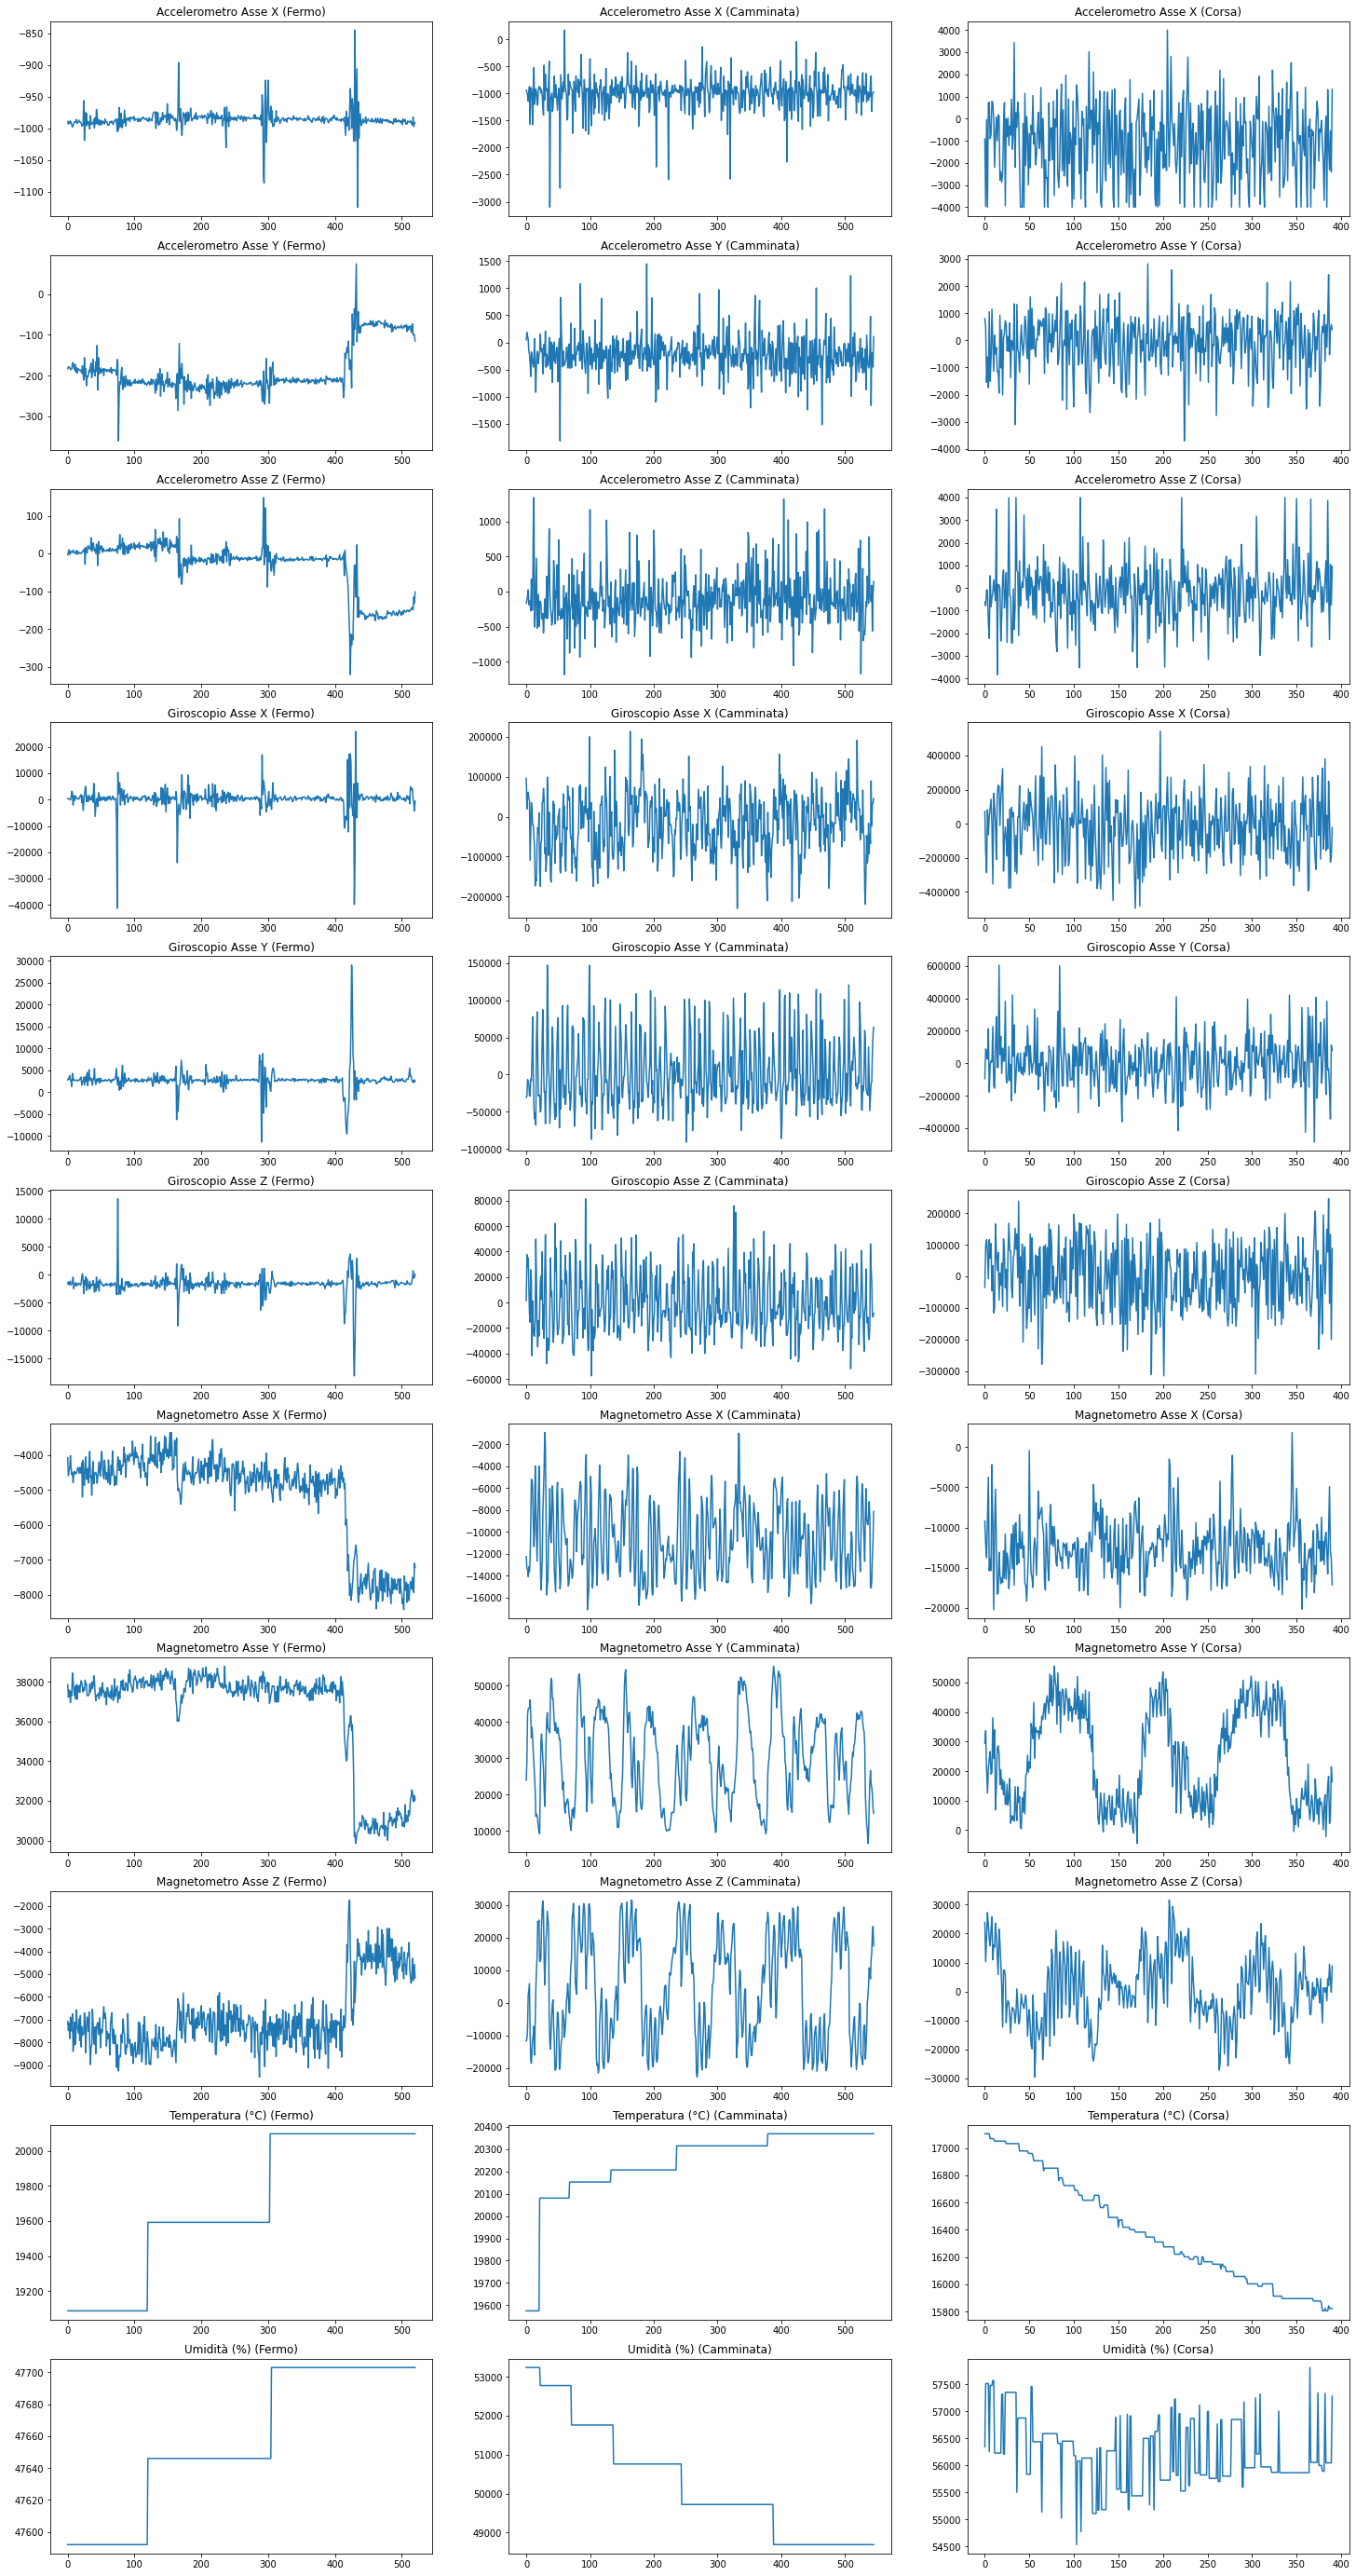

In [3]:
# relevant features
still = pd.read_csv('datasets/still_19_02_2023_17_28_18.csv')
walking = pd.read_csv('datasets/walking_19_02_2023_17_10_11.csv')
running = pd.read_csv('datasets/running_23_02_2023_10_48_27.csv')


fig, axs = plt.subplots(still.shape[1],3)

fig.set_figheight(50)
fig.set_figwidth(25)


for i in range (still.shape[1]):
    title = ''

    if i == 0:
        title = "Accelerometro Asse X"
    elif i == 1:
        title = "Accelerometro Asse Y"
    elif i == 2:
        title = "Accelerometro Asse Z"
    elif i == 3:
        title = "Giroscopio Asse X"
    elif i == 4:
        title = "Giroscopio Asse Y"
    elif i == 5:
        title = "Giroscopio Asse Z"
    elif i == 6:
        title = "Magnetometro Asse X"
    elif i == 7:
        title = "Magnetometro Asse Y"
    elif i == 8:
        title = "Magnetometro Asse Z"
    elif i == 9:
        title = "Temperatura (°C)"
    else:
        title = "Umidità (%)"

    axs[i,0].plot(np.arange(0, still.shape[0]), still[still.columns[i]])
    axs[i,0].set_title(f'{title} (Fermo)')

    axs[i,1].plot(np.arange(0, walking.shape[0]), walking[walking.columns[i]])
    axs[i,1].set_title(f'{title} (Camminata)')

    axs[i,2].plot(np.arange(0, running.shape[0]), running[running.columns[i]])
    axs[i,2].set_title(f'{title} (Corsa)')

Lettura dei dataset dalla cartella datasets

In [4]:
# list of files inside datasets folder
files = listdir('datasets')

datasets = []

# for every file add a label
def divide_and_add_activity(name, df):
    # aggiungo la label dell'attvità
    if 'still' in name:
        df['activity'] = 'still'
    elif 'walking' in name:
        df['activity'] = 'walking'
    else:
        df['activity'] = 'running'
    return df

# add activity to the labels we are interested
labels = ['xa', 'ya', 'za', 'xg', 'yg', 'zg', 'activity']

for file in files:
    df = divide_and_add_activity(file, pd.read_csv(f'datasets/{file}'))
    df = df[labels]
    datasets.append(df)
    print("Dimensione dataset {} ".format(file), df.shape)


df_data = pd.concat(datasets)

print("Dimensione merged dataset", df_data.shape)
print(df_data)



Dimensione dataset running_23_02_2023_10_46_08.csv  (420, 7)
Dimensione dataset running_23_02_2023_10_48_27.csv  (391, 7)
Dimensione dataset running_23_02_2023_10_55_12.csv  (481, 7)
Dimensione dataset still_19_02_2023_17_28_18.csv  (521, 7)
Dimensione dataset still_20_02_2023_15_28_07.csv  (1230, 7)
Dimensione dataset still_20_02_2023_15_30_50.csv  (814, 7)
Dimensione dataset still_20_02_2023_15_33_07.csv  (739, 7)
Dimensione dataset still_20_02_2023_15_35_32.csv  (830, 7)
Dimensione dataset still_20_02_2023_15_40_22.csv  (1710, 7)
Dimensione dataset still_20_02_2023_15_49_25.csv  (1284, 7)
Dimensione dataset still_20_02_2023_15_58_11.csv  (670, 7)
Dimensione dataset still_20_02_2023_16_00_41.csv  (840, 7)
Dimensione dataset walking_19_02_2023_17_10_11.csv  (546, 7)
Dimensione dataset walking_19_02_2023_17_16_37.csv  (705, 7)
Dimensione dataset walking_19_02_2023_17_19_05.csv  (654, 7)
Dimensione dataset walking_19_02_2023_17_21_28.csv  (790, 7)
Dimensione dataset walking_19_02_2023_1

Normalizzazione dei dati

,xa,ya,za,xg,yg,zg,activity
0,0.428232,0.424494,0.375594,0.298468,0.386082,0.530473,running
1,0.000000,0.435537,0.561265,0.275907,0.295563,0.464691,running
2,0.279320,0.664133,0.461615,0.542472,0.465577,0.371260,running
3,0.646412,0.629858,0.484496,0.450837,0.442317,0.441242,running
4,0.548262,0.646924,0.474244,0.505559,0.398085,0.341881,running
...,...,...,...,...,...,...,...
641,0.478370,0.609924,0.523506,0.653015,0.479963,0.447354,walking
642,0.462991,0.575792,0.491748,0.504040,0.558851,0.461133,walking
643,0.475369,0.534203,0.435609,0.508177,0.426296,0.421077,walking
644,0.387347,0.654525,0.702801,0.473657,0.428772,0.406478,walking


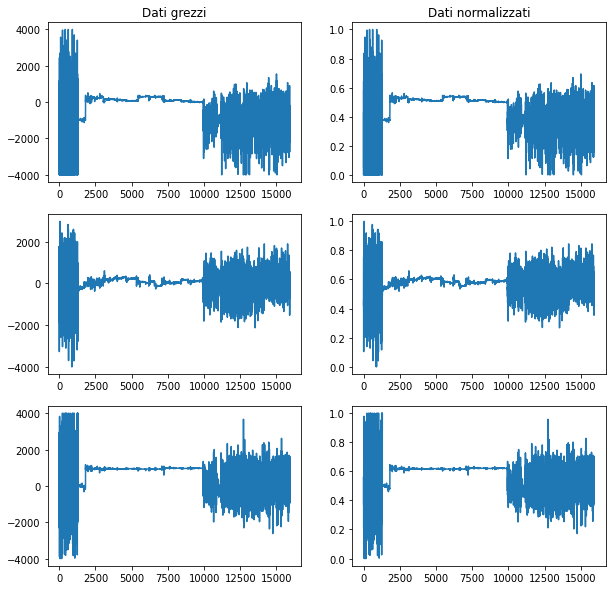

In [5]:
normalizer = MinMaxScaler()
num_columns = df_data.shape[1]

normalizer.fit(df_data.iloc[:, 0 : num_columns-1])

def minmax_normalizer(df):
    
    norm_df = df.copy()
    norm_column = normalizer.transform(df.iloc[:, 0 : num_columns-1])
    norm_df.iloc[:, 0 : num_columns-1] = norm_column

    return norm_df


def arduino_normalizer(df):
    norm_df = df.copy()
    labels = ['xa', 'ya', 'za', 'xg', 'yg', 'zg']
    norm_df[labels] = norm_df[labels] / 1000.0
    norm_df['xa'] = (norm_df['xa'] + 4.0) / 8.0
    norm_df['ya'] = (norm_df['ya'] + 4.0) / 8.0
    norm_df['za'] = (norm_df['za'] + 4.0) / 8.0
    norm_df['xg'] = (norm_df['xg'] + 2000.0) / 4000.0
    norm_df['yg'] = (norm_df['yg'] + 2000.0) / 4000.0
    norm_df['zg'] = (norm_df['zg'] + 2000.0) / 4000.0
    return norm_df


norm_df = minmax_normalizer(df_data)

# visualizzazione dati grezzi e normalizzati dell'accelerometro
fig, ((ax1, ax2),( ax3, ax4), (ax5, ax6)) = plt.subplots(3,2)
fig.set_figheight(10)
fig.set_figwidth(10)
ax1.plot(np.arange(0, len(df_data.xa)), df_data.xa)
ax1.set_title('Dati grezzi')
ax3.plot(np.arange(0, len(df_data.ya)), df_data.ya)
ax5.plot(np.arange(0, len(df_data.za)), df_data.za)

ax2.plot(np.arange(0, len(norm_df.xa)), norm_df.xa)
ax2.set_title('Dati normalizzati')
ax4.plot(np.arange(0, len(norm_df.ya)), norm_df.ya)
ax6.plot(np.arange(0, len(norm_df.za)), norm_df.za)


norm_df

Resize datasets

In [6]:
def reshape_data(df, time_steps, step):
    Xs = []
    ys = []

    num_cols = df.shape[1]

    X = df.iloc[:, :num_cols - 1]
    y = df.iloc[:, num_cols - 1:]

    print(X.shape)

    for i in range(0, len(X) - time_steps, step):
        values = X.iloc[i : (i+time_steps)].values
        labels = y.iloc[i : i + time_steps]
        Xs.append(values)
        ys.append(labels.mode()['activity'][0])
    
    return np.array(Xs), np.array(ys).reshape(-1, 1)


X_data, y_data = reshape_data(norm_df, 20, 20)
print(X_data.shape)

(15920, 6)
(795, 20, 6)


Split test and train data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=42)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (532, 20, 6)
X_test shape:  (263, 20, 6)
y_train shape:  (532, 1)
y_test shape:  (263, 1)


OneHotEncoder per la y

In [8]:
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(y_train)

def encode_y(y):
    encoded_y = encoder.transform(y)
    return encoded_y

encoded_y_train = encode_y(y_train)
encoded_y_test = encode_y(y_test)


print(encoder.categories_)
# print(y_train)
print(pd.DataFrame(encoded_y_train, columns=encoder.categories_))

[array(['running', 'still', 'walking'], dtype='<U7')]
    running still walking
0       0.0   1.0     0.0
1       0.0   0.0     1.0
2       0.0   1.0     0.0
3       0.0   1.0     0.0
4       1.0   0.0     0.0
..      ...   ...     ...
527     0.0   1.0     0.0
528     0.0   1.0     0.0
529     0.0   1.0     0.0
530     0.0   1.0     0.0
531     0.0   1.0     0.0

[532 rows x 3 columns]


In [9]:
# stampa delle dimensioni

print(X_train.shape)
print(X_test.shape)

print(encoded_y_train.shape)
print(encoded_y_test.shape)
encoded_y_train

(532, 20, 6)
(263, 20, 6)
(532, 3)
(263, 3)


array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

# Modello

In [10]:
model = Sequential()
model.add(Dense(16, input_shape=[X_train.shape[1], X_train.shape[2]], activation='relu'))
# model.add(Dropout(rate=0.1))
model.add(Dense(32, activation = 'relu'))
# model.add(Dropout(rate=0.1))
model.add(Dense(32, activation = 'relu'))
# model.add(Dropout(rate=0.1))
model.add(Flatten())
model.add(Dense(encoded_y_train.shape[1], activation = 'softmax'))
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20, 16)            112       
                                                                 
 dense_1 (Dense)             (None, 20, 32)            544       
                                                                 
 dense_2 (Dense)             (None, 20, 32)            1056      
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1923      
                                                                 
Total params: 3,635
Trainable params: 3,635
Non-trainable params: 0
_________________________________________________________________
None


Modello - ottimizzatore e funzione di perdita

In [11]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

Early stopping per evitare overfitting

In [12]:
early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

In [13]:
history = model.fit(
    X_train, encoded_y_train,
    validation_data=(X_test, encoded_y_test),
    batch_size=3,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
178/178 [==============================] - 1s 3ms/step - loss: 0.9085 - accuracy: 0.5263 - val_loss: 0.8329 - val_accuracy: 0.5665
Epoch 2/50
178/178 [==============================] - 0s 1ms/step - loss: 0.5339 - accuracy: 0.8421 - val_loss: 0.3600 - val_accuracy: 0.8479
Epoch 3/50
178/178 [==============================] - 0s 1ms/step - loss: 0.2457 - accuracy: 0.9117 - val_loss: 0.1926 - val_accuracy: 0.9125
Epoch 4/50
178/178 [==============================] - 0s 1ms/step - loss: 0.1278 - accuracy: 0.9643 - val_loss: 0.1998 - val_accuracy: 0.9316
Epoch 5/50
178/178 [==============================] - 0s 1ms/step - loss: 0.1237 - accuracy: 0.9605 - val_loss: 0.0945 - val_accuracy: 0.9886
Epoch 6/50
178/178 [==============================] - 0s 1ms/step - loss: 0.0851 - accuracy: 0.9680 - val_loss: 0.1093 - val_accuracy: 0.9392
Epoch 7/50
178/178 [==============================] - 0s 1ms/step - loss: 0.0633 - accuracy: 0.9812 - val_loss: 0.1153 - val_accuracy: 0.9392
Epoch 

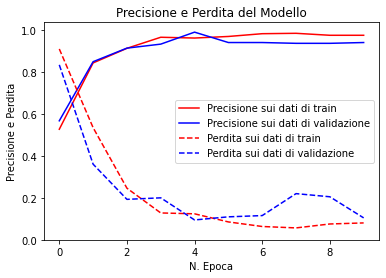

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Precisione sui dati di train')
plt.plot(history.history['val_accuracy'], 'b', label='Precisione sui dati di validazione')
plt.plot(history.history['loss'], 'r--', label='Perdita sui dati di train')
plt.plot(history.history['val_loss'], 'b--', label='Perdita sui dati di validazione')
plt.title('Precisione e Perdita del Modello')
plt.ylabel('Precisione e Perdita')
plt.xlabel('N. Epoca')
plt.ylim(0)
plt.legend()
plt.show()

Matrice per l'affidabilità della predizione sui dati di validazione

9/9 [==============================] - 0s 875us/step


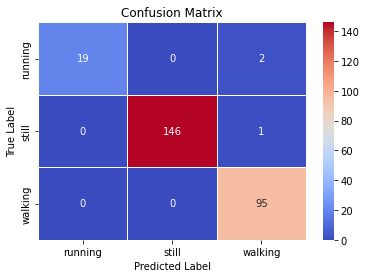

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       1.00      0.99      1.00       147
           2       0.97      1.00      0.98        95

    accuracy                           0.99       263
   macro avg       0.99      0.97      0.98       263
weighted avg       0.99      0.99      0.99       263



In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
def show_confusion_matrix(validations, predictions):

    matrix = confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=['running', 'still', 'walking'],
                yticklabels=['running', 'still', 'walking'],
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model.predict(X_test)

# indice della massima probabilità
max_y_pred_test = np.argmax(y_pred_test, axis=1)

max_y_test = np.argmax(encoded_y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

In [16]:
model.evaluate(X_test, encoded_y_test)

9/9 [==============================] - 0s 1ms/step - loss: 0.0945 - accuracy: 0.9886


[0.09449601173400879, 0.9885931611061096]

piccolo test con alcuni dati in input

In [17]:
data_still = pd.read_csv('datasets/running_23_02_2023_10_48_27.csv')[labels[0:-1]]
data_norm = minmax_normalizer(data_still)

data_input = np.array([data_norm.iloc[7:27,:], data_norm.iloc[30:50,:]])
print(data_input.shape)
print(data_input)

res = model.predict(data_input)
print(res)
print(np.argmax(res[0]))

(2, 20, 6)
[[[0.40810203 0.47798652 0.39709927 0.56306105 0.45581445 0.62709734]
  [0.5983996  0.73884985 0.44623656 0.48606925 0.45030312 0.40337607]
  [0.58764691 0.56345906 0.47874469 0.29959938 0.61676801 0.52299146]
  [0.49949987 0.41058368 0.54551138 0.58148498 0.33764603 0.29835831]
  [0.22468117 0.60074573 0.479995   0.54243938 0.32643664 0.32408841]
  [0.41247812 0.50193604 0.4299825  0.48183477 0.53372228 0.71961629]
  [0.50900225 0.53535064 0.93585896 0.37597793 0.66454947 0.58667841]
  [0.37471868 0.40757206 0.02150538 0.57873755 0.42368082 0.49936019]
  [0.52075519 0.4108705  0.52063016 0.60702005 0.42554956 0.58512671]
  [0.51612903 0.29456475 0.51662916 0.60252713 0.90723942 0.35894185]
  [0.15228807 0.70572207 0.49762441 0.48047747 0.48453965 0.48768208]
  [0.20130033 0.42836656 0.20730183 0.56542084 0.56996683 0.4296533 ]
  [0.14103526 0.6295712  0.33945986 0.61002592 0.39532983 0.53403274]
  [0.18654664 0.28524308 0.55713928 0.65831632 0.51578711 0.32855815]
  [0.4439

In [18]:
data_still = pd.read_csv('datasets/running_23_02_2023_10_48_27.csv')[labels[0:-1]]

data_norm = minmax_normalizer(data_still)

data_input = []

count_still = 0
count_walking = 0
count_running = 0

# resize data in signals of 20 samples
for i in range(0, data_norm.shape[0]-20, 20):
    data_input.append(data_norm.iloc[i:(i+20), :])

input = np.array(data_input)
print(input.shape)

# classify the input
res = model.predict(input)
print(res)

# get the index of the biggest probability (0 = still, 1 = walking)
res = np.argmax(res, axis=1)
print(res)

for value in res:
    if value == 0:
        count_running += 1
    elif value == 1:
        count_still +=1
    else:
        count_walking += 1

print('Still: ', count_still)
print('Walking: ', count_walking)
print('Running: ', count_running)




(19, 20, 6)
1/1 [==============================] - 0s 15ms/step
[[9.93918657e-01 6.89522395e-09 6.08134875e-03]
 [9.92975712e-01 1.27271447e-08 7.02428957e-03]
 [8.78828526e-01 4.98874078e-06 1.21166512e-01]
 [7.77361393e-01 1.95066714e-05 2.22619101e-01]
 [9.95434344e-01 2.98198088e-08 4.56569158e-03]
 [9.98251855e-01 2.12603171e-10 1.74810109e-03]
 [9.68783259e-01 1.54982604e-06 3.12152132e-02]
 [9.86221552e-01 2.62603876e-08 1.37784425e-02]
 [9.31143880e-01 7.27824840e-07 6.88553602e-02]
 [9.97445822e-01 2.38562041e-08 2.55418080e-03]
 [9.02110636e-01 5.36367224e-06 9.78839397e-02]
 [7.39298105e-01 8.93093093e-05 2.60612607e-01]
 [8.97939384e-01 7.84451277e-06 1.02052823e-01]
 [8.80000114e-01 7.48054845e-06 1.19992465e-01]
 [9.11212742e-01 1.49414416e-06 8.87857601e-02]
 [9.46773231e-01 2.94884899e-07 5.32263815e-02]
 [9.81712103e-01 7.53565075e-07 1.82871670e-02]
 [9.20961201e-01 3.93546588e-06 7.90349096e-02]
 [9.91261601e-01 8.96662016e-08 8.73829704e-03]]
[0 0 0 0 0 0 0 0 0 0 0 

Coverti il modello keras in un modello tensorflow lite

In [19]:
model.save('activity_classifier_model')

# convert model to tensorflow lite
converter = tf.lite.TFLiteConverter.from_saved_model('activity_classifier_model')
tflite_model = converter.convert()

# Save the model to disk
with open("./activity_classifier.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: activity_classifier_model\assets


INFO:tensorflow:Assets written to: activity_classifier_model\assets


In [23]:
data_vis = pd.read_csv('datasets/running_23_02_2023_10_48_27.csv')[labels[0:-1]]
data_norm = minmax_normalizer(data_still)

data_zero = np.zeros(20 * 6).reshape([1,20,6])

res = model.predict(data_zero)
print(res)



1/1 [==============================] - 0s 16ms/step
[[9.9998605e-01 4.6911338e-12 1.3968180e-05]]
